This notebook implements Layer-Wise Relevance Propagation as detailed in

<span style="color:blue">G. Montavon, A. Binder, S. Lapuschkin, W. Samek, K.-R. MüllerLayer-wise Relevance Propagation: An Overviewin Explainable AI: Interpreting, Explaining and Visualizing Deep Learning, Springer LNCS, vol. 11700, 2019.</span>

It borrows heavily from https://git.tu-berlin.de/gmontavon/lrp-tutorial.

In [1]:
import numpy as np
import copy
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from Data import CSVData

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
model_path = '/raid/projects/asinha15/VLQ-NN-Reweighting/trained_models/model_scripted6.pt'
model = torch.jit.load(model_path).to(device)
model.eval()

RecursiveScriptModule(
  original_name=Sequential
  (Linear0): RecursiveScriptModule(original_name=Linear)
  (Activation0): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear1): RecursiveScriptModule(original_name=Linear)
  (Activation1): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear2): RecursiveScriptModule(original_name=Linear)
  (Activation2): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear_last): RecursiveScriptModule(original_name=Linear)
  (Activation_last): RecursiveScriptModule(original_name=LeakyReLU)
)

In [4]:
features = ['mode',
'Msim',
'Gsim',
'weight',
'pz_in1',
'pid_in1', 
'pz_in2',
'pid_in2',
'px_out1',
'py_out1',
'pz_out1',
'e_out1',
'pid_out1',
'px_out2',
'py_out2',
'pz_out2',
'e_out2',
'pid_out2',
'px_out3',
'py_out3',
'pz_out3',
'e_out3',
'pid_out3',
'px_out4',
'py_out4',
'pz_out4',
'e_out4',
'pid_out4',
'Mtarget',
'Gtarget',]
label = 'f_rwt'
features_to_rescale = ['Msim',
'Gsim',
'pz_in1', 
'pz_in2',
'px_out1',
'py_out1',
'pz_out1',
'e_out1',
'px_out2',
'py_out2',
'pz_out2',
'e_out2',
'px_out3',
'py_out3',
'pz_out3',
'e_out3',
'px_out4',
'py_out4',
'pz_out4',
'e_out4',
'Mtarget',
'Gtarget']

train_data = CSVData(batch_size=1024, features_name=features, labels_name=label, features_to_rescale= features_to_rescale, file_names=['/raid/projects/asinha15/train_' + str(i)+'.csv' for i in range(0,10)])

In [5]:
X, Y = train_data.load_data_many()
X = np.array(X)
Y = np.log(np.array(Y))

In [6]:
W = []
B = []
for name, param in model.named_parameters():
    if 'weight' in name:
        W.append(param.cpu().detach().numpy().transpose())
    elif 'bias' in name:
        B.append(param.cpu().detach().numpy())
L = len(W)

In [7]:
A = [X]+[None]*L
for l in range(L):
    A[l+1] = np.maximum(-0.01*(A[l].dot(W[l])+B[l]),A[l].dot(W[l])+B[l]) #forward pass with LeakyRelu activation

In [8]:
A[L]

array([[0.86830737],
       [0.67705935],
       [1.03064062],
       ...,
       [1.85107138],
       [3.43598782],
       [4.26477763]])

In [9]:
def rho(w,l):  
    return w + [None,0.1,0.0,0.0][l] * w
def incr(z,l): 
    return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

In [10]:
R = [None]*L + [A[L]*Y[:, None]] #Set the top layer relevance scores to top layer activation * label

In [11]:
R

[None,
 None,
 None,
 None,
 array([[ -1.27279519],
        [ -1.02936582],
        [ -1.62828463],
        ...,
        [ -4.73741941],
        [-15.45220022],
        [-22.3340278 ]])]

Following the steps for propagation:
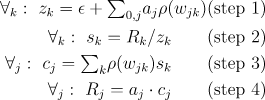

In [12]:
for l in range(1,L)[::-1]:
    w = rho(W[l],l)
    b = rho(B[l],l)
    
    z = incr(A[l].dot(w)+b,l)                # step 1
    s = R[l+1] / z                           # step 2
    c = w.dot(s.transpose()).transpose()     # step 3
    R[l] = A[l]*c                            # step 4

In [13]:
# for the last layer which takes the features as inputs
w  = W[0]
wp = np.maximum(0,w)
wm = np.minimum(0,w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9        # step 1
s = R[1]/z                                        # step 2
c,cp,cm  = s.dot(w.transpose()),s.dot(wp.transpose()),s.dot(wm.transpose())          # step 3
R[0] = A[0]*c-lb*cp-hb*cm                         # step 4

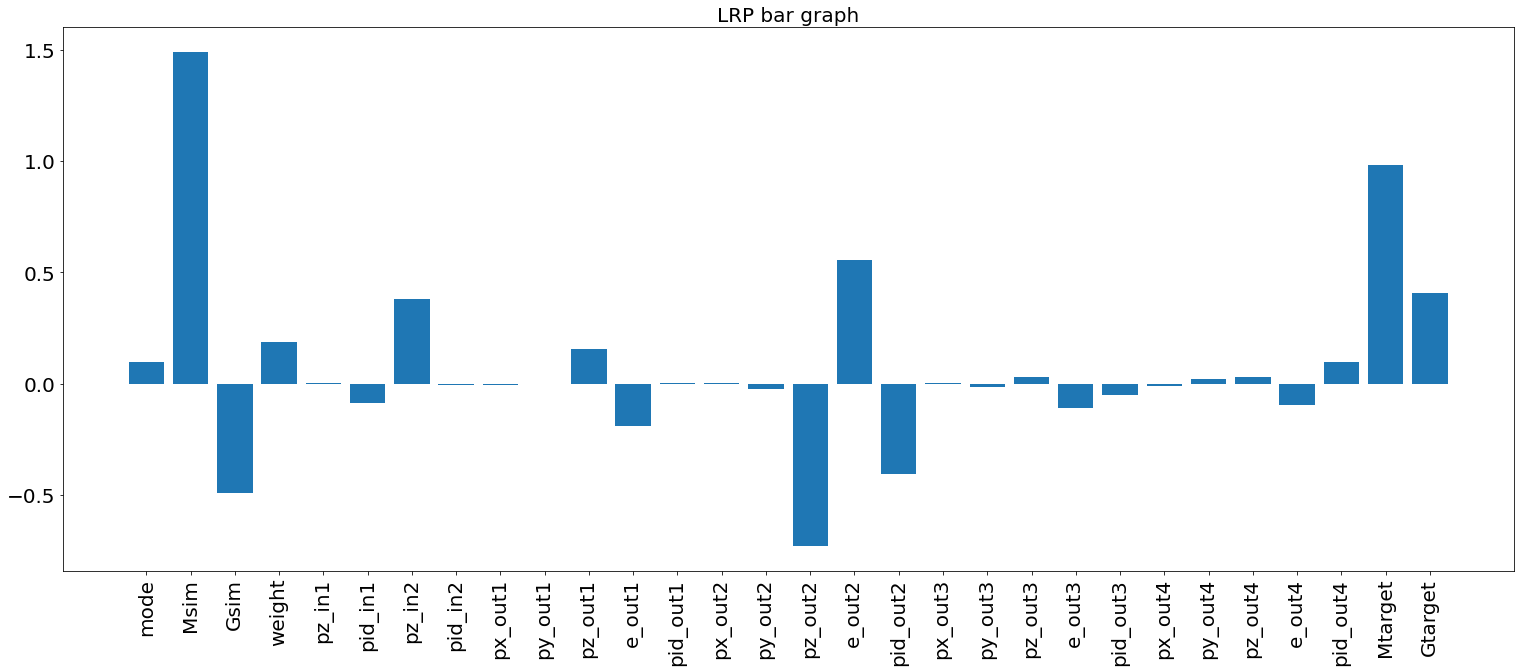

In [14]:
plt.rcParams["figure.figsize"] = (26,10)
plt.bar(features, np.mean(R[0]/Y[:, np.newaxis], axis=0))
plt.xticks(features, features, rotation=90, size=20)
plt.yticks(size=20)
plt.title('LRP bar graph', size=20)
plt.show()

In [15]:
matplotlib.rcParams.update({'axes.titlesize': 'xx-large'})
matplotlib.rcParams.update({'axes.labelsize': 'xx-large'})

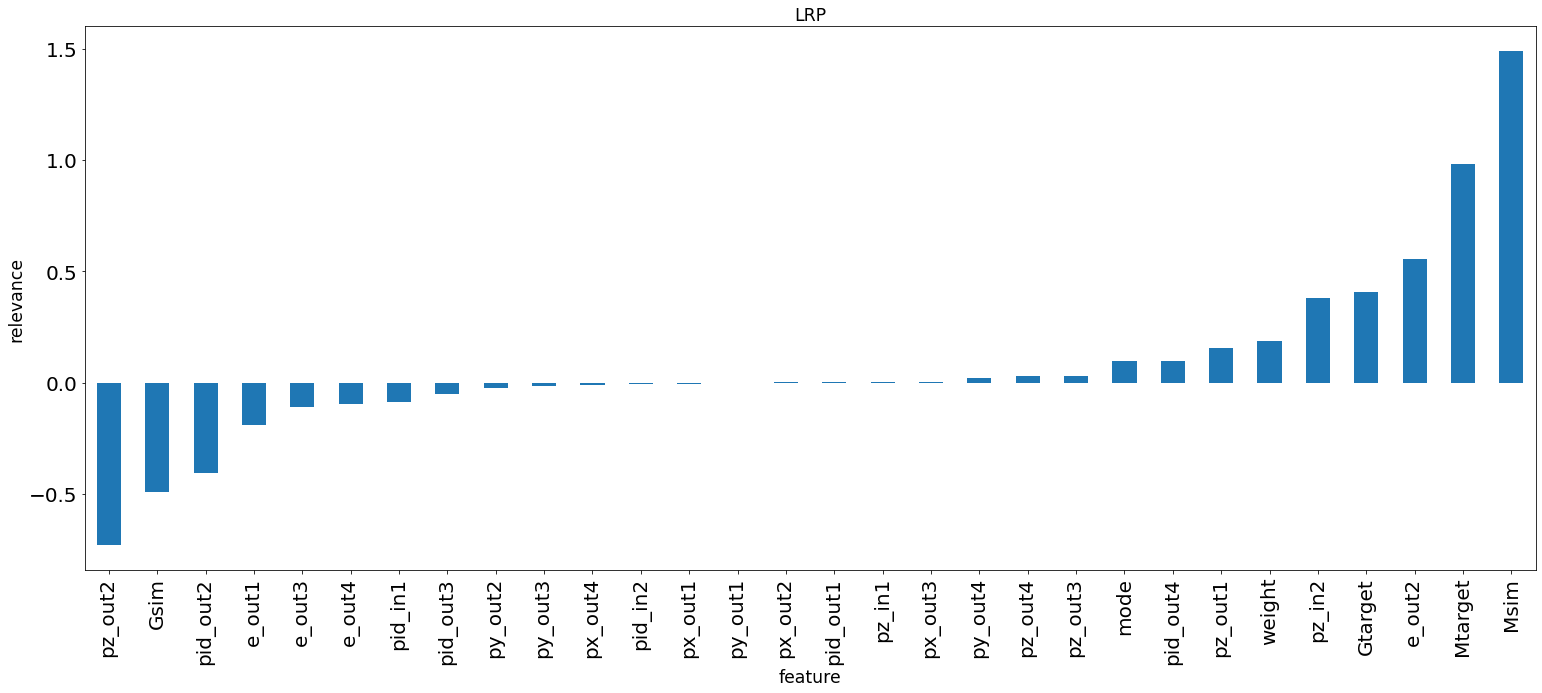

In [16]:
df = pd.DataFrame(np.array([features, np.mean(R[0]/Y[:, np.newaxis], axis=0)]).transpose())
df.columns=['feature', 'relevance']
df.relevance = df.relevance.astype(float)
df = df.sort_values(by=['relevance'])
df.plot.bar(x='feature', y='relevance', legend=False, fontsize=20, xlabel='feature', ylabel='relevance', title='LRP')
del df

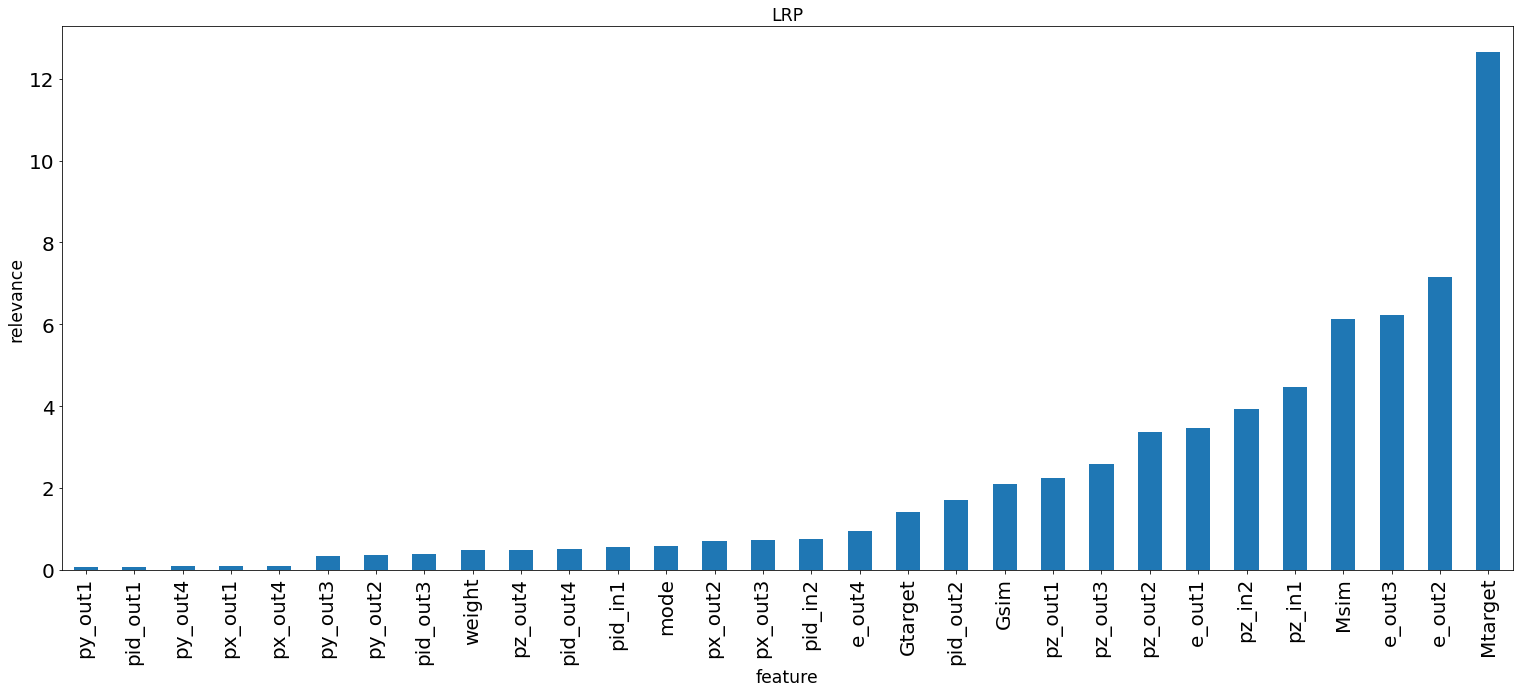

In [17]:
df = pd.DataFrame(np.array([features, np.mean(np.abs(R[0]/Y[:, np.newaxis]), axis=0)]).transpose())
df.columns=['feature', 'relevance']
df.relevance = df.relevance.astype(float)
df = df.sort_values(by=['relevance'])
df.plot.bar(x='feature', y='relevance', legend=False, fontsize=20, xlabel='feature', ylabel='relevance', title='LRP')
del df

Now we can display the results on a per-mode basis.

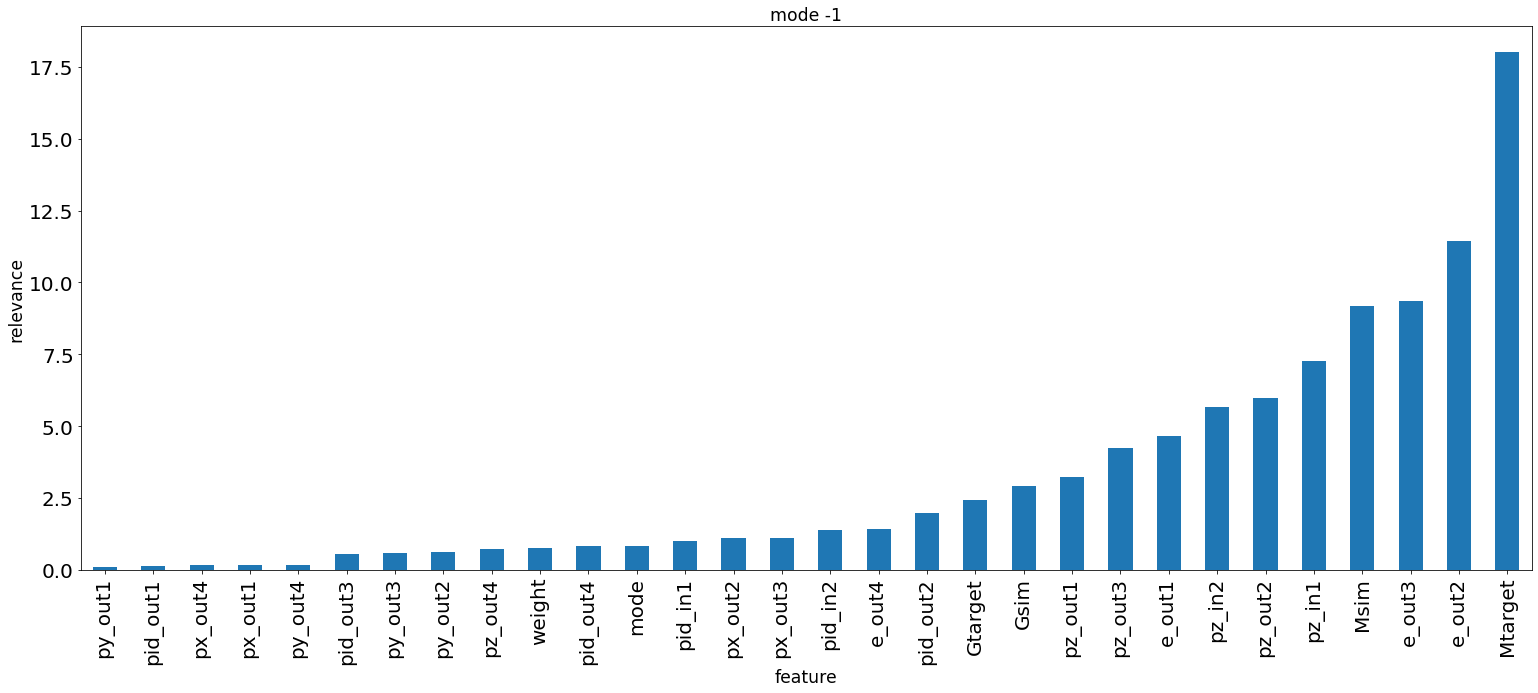

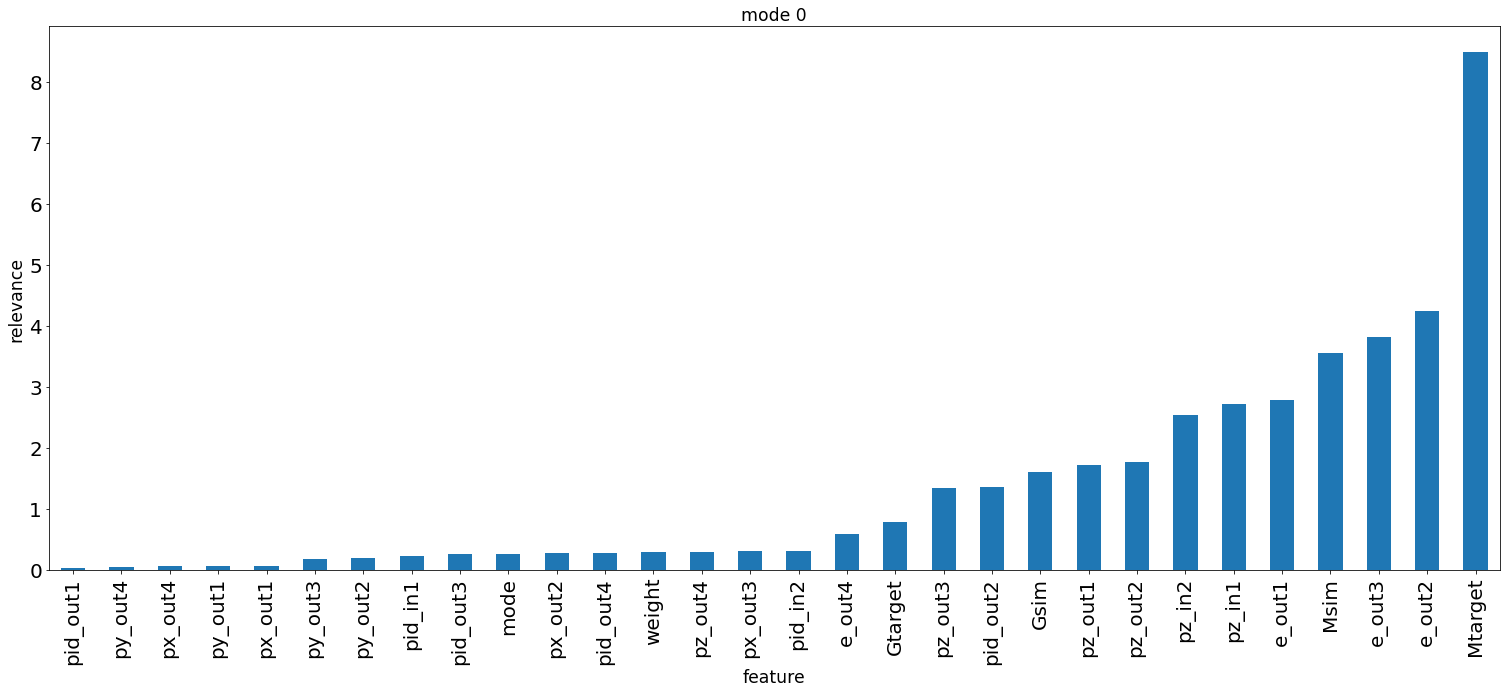

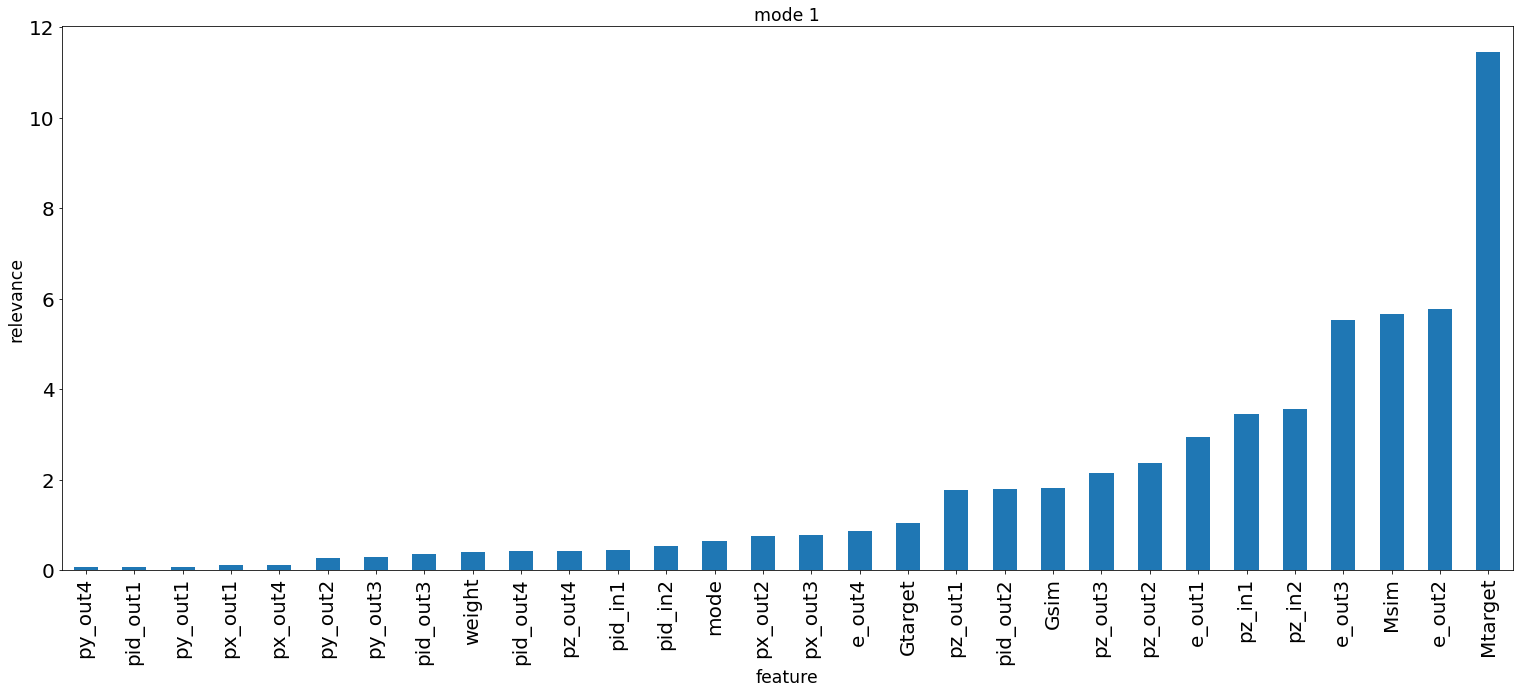

In [21]:
df_all = pd.DataFrame(X)
df_all.columns = features
rels = R[0]/Y[:, np.newaxis]
modes = [-1,0,1]
for i, b in enumerate(modes):
    idx = df_all.index[df_all['mode']==b].tolist()
    rel_mode = pd.DataFrame(np.array([features, np.mean(np.abs([rels[idxi][:] for idxi in idx]), axis=0)])).transpose()
    rel_mode.columns = ['feature', 'relevance']
    rel_mode.relevance = rel_mode.relevance.astype(float)
    rel_mode = rel_mode.sort_values(by=['relevance'])
    rel_mode.plot.bar(x='feature', y='relevance', legend=False, fontsize=20, xlabel='feature', ylabel='relevance', title='mode '+str(b))
    del rel_mode
del df_all, rels

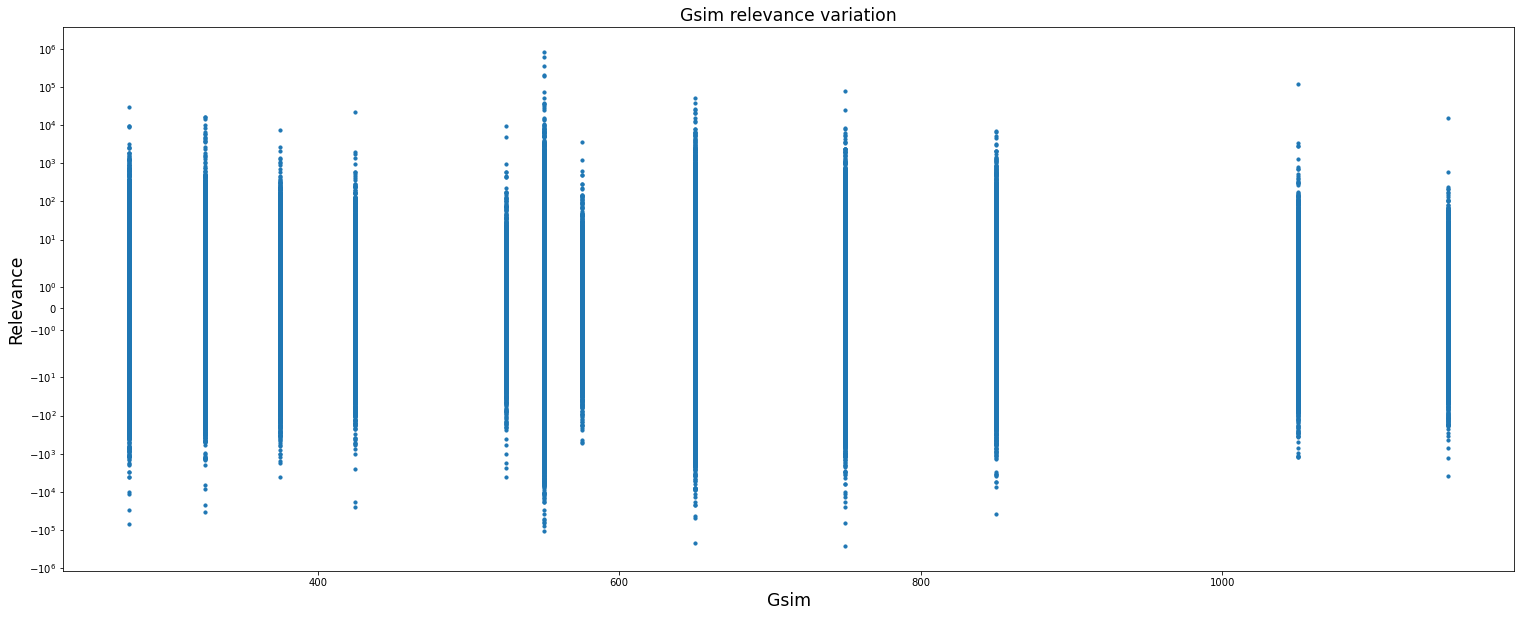

In [22]:
plt.title('Gsim relevance variation')
plt.scatter(X[:,2], R[0][:,2]/Y, s=10)
plt.xlabel('Gsim')
plt.ylabel('Relevance')
plt.yscale('symlog')
plt.show()

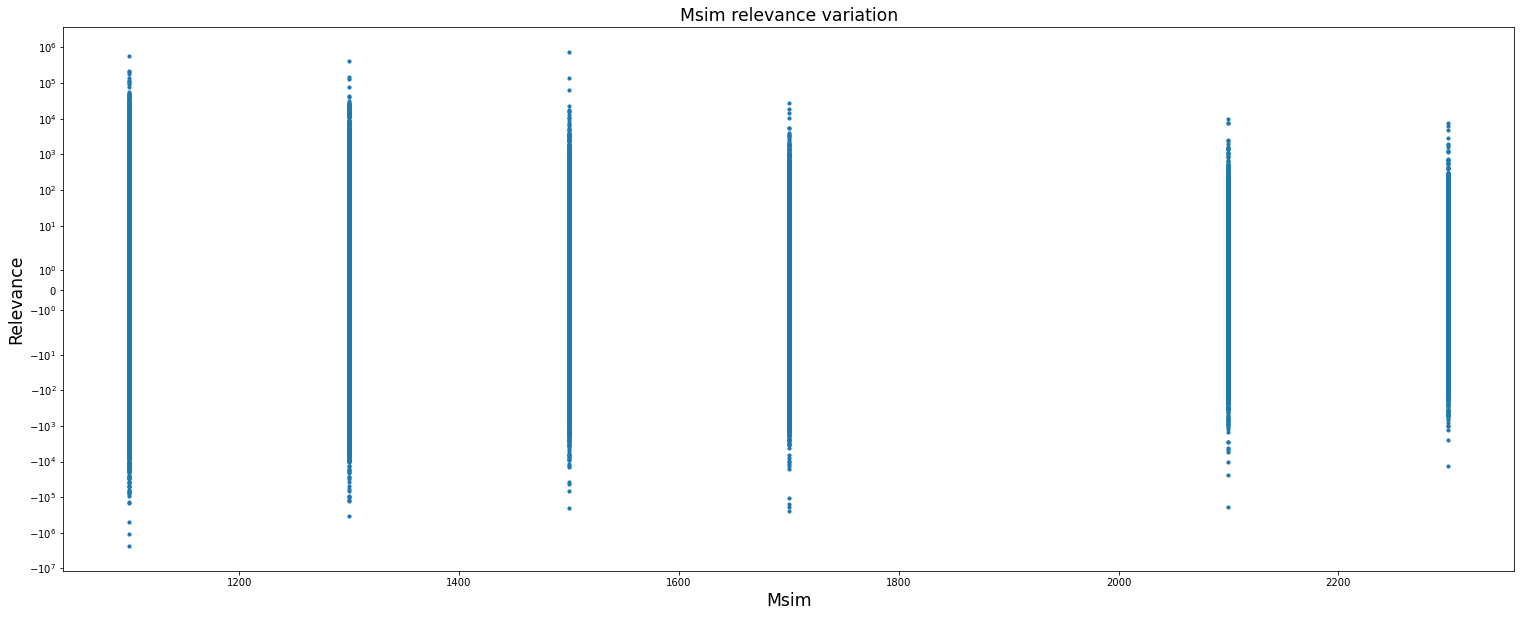

In [23]:
plt.title('Msim relevance variation')
plt.scatter(X[:,1], R[0][:,1]/Y, s=10)
plt.xlabel('Msim')
plt.ylabel('Relevance')
plt.yscale('symlog')
plt.show()

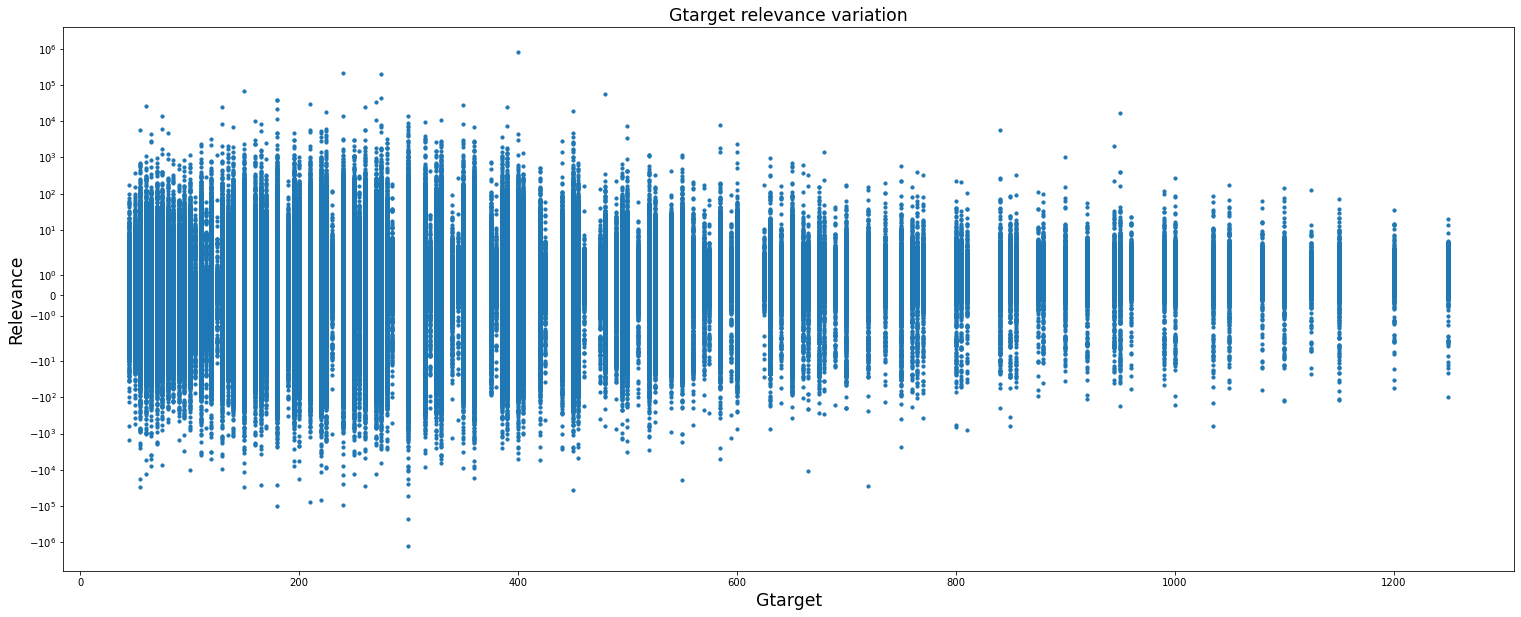

In [24]:
plt.title('Gtarget relevance variation')
plt.scatter(X[:,29], R[0][:,29]/Y, s=10)
plt.xlabel('Gtarget')
plt.ylabel('Relevance')
plt.yscale('symlog')
plt.show()

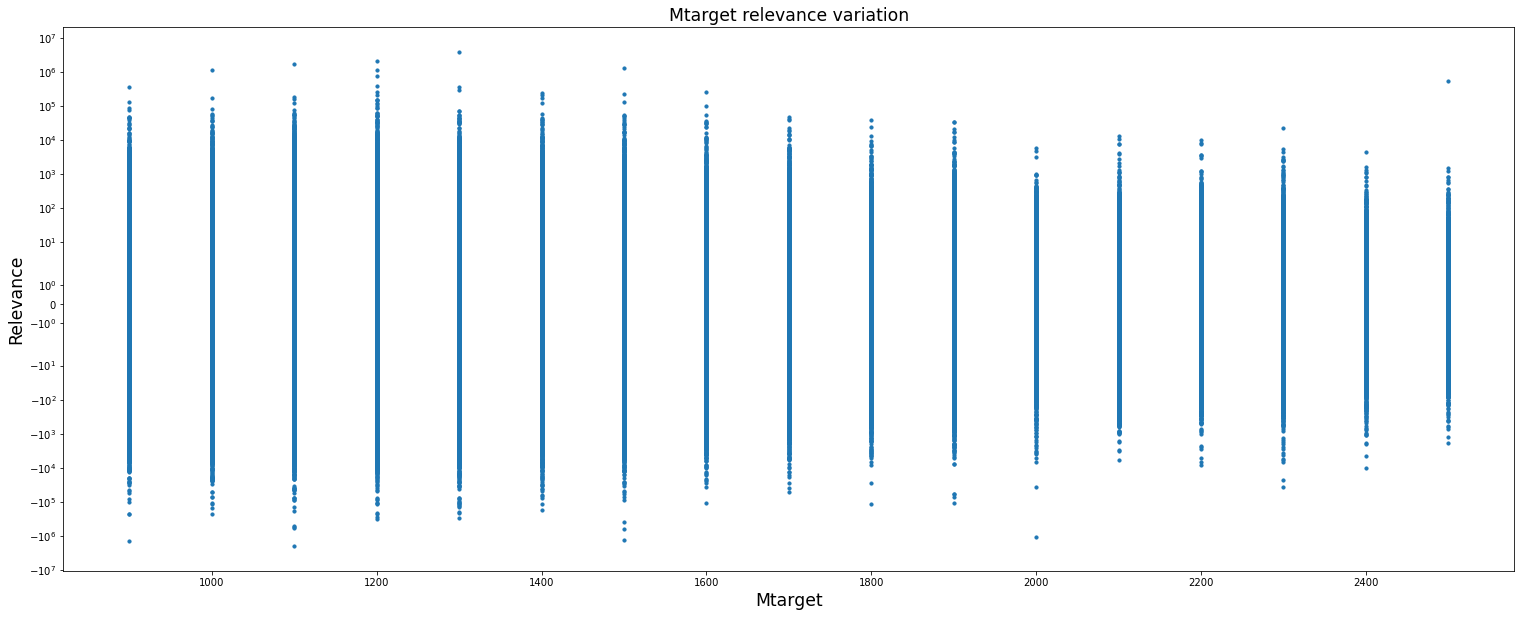

In [25]:
plt.title('Mtarget relevance variation')
plt.scatter(X[:,28], R[0][:,28]/Y, s=10)
plt.xlabel('Mtarget')
plt.ylabel('Relevance')
plt.yscale('symlog')
plt.show()